In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from omars_little_helpers import *
from scipy.interpolate import interp1d
import pickle
from ode_system import *
import contextlib
import io

In [3]:
path_to_GR_pickle = "GR_TOV_solutions.pkl"

with open(path_to_GR_pickle, 'rb') as file:
    GR_results = pickle.load(file)
    
GR_results[0].keys()

dict_keys(['mass', 'radius', 'rho_c', 'rho_values', 'mass_values'])

In [4]:
path_to_pickle = "./output/full_star_solutions.pkl"

with open(path_to_pickle, 'rb') as file:
    results = pickle.load(file)
    
results[0].keys()

GR_mass = []
GR_radius = []
GR_rho_c = []

for result in GR_results:
    GR_mass.append(result["mass"])
    GR_radius.append(result["radius"])
    GR_rho_c.append(result["rho_c"])

GR_mass = np.array(GR_mass)
GR_radius = np.array(GR_radius)
GR_rho_c = np.array(GR_rho_c)
#GR_MR_interp = interp1d(GR_radius, GR_mass, kind='quadratic')
#GR_radii = np.linspace(min(GR_radius), max(GR_radius), 10000)

In [8]:
idx = 99
print(f"{GR_rho_c[idx]:0.3e}")
print(GR_radius[idx])
print(GR_mass[idx])

4e14 - 1.778e+16

1.778e+16
7.9945650354217195
1.8199240583892577


In [11]:
rho_c = create_r_mesh(4e14,1.778e16, 50)

In [14]:
rho_c

[400000000000000.1,
 432205239448448.94,
 467003422516727.6,
 504603315130218.44,
 545230491605842.9,
 589128687947747.0,
 636561264101016.1,
 687812783935967.4,
 743190722441872.5,
 803027310372138.0,
 867681527407584.4,
 937541255795477.0,
 1013025607384708.9,
 1094587438017796.0,
 1182716064364369.0,
 1277940199495323.0,
 1380831124809186.2,
 1492006117340063.2,
 1612132153008781.2,
 1741929908034259.0,
 1882178082510903.5,
 2033718072090618.2,
 2197459015796408.5,
 2374383250251098.5,
 2565552203042905.5,
 2772112760584136.0,
 2995304148665917.5,
 3236465366987713.0,
 3497043222263840.5,
 3778601008100296.0,
 4082827883715346.5,
 4411549007769987.0,
 4766736488104485.0,
 5150521213072143.0,
 5565205635450402.0,
 6013277585624244.0,
 6497425196911792.0,
 7020553032574143.0,
 7585799511260603.0,
 8196555735430788.0,
 8856485835711051.0,
 9569548953238226.0,
 1.034002299186995e+16,
 1.1172530282759046e+16,
 1.2072065315262298e+16,
 1.3044024700550638e+16,
 1.4094239547682424e+16,
 1.5

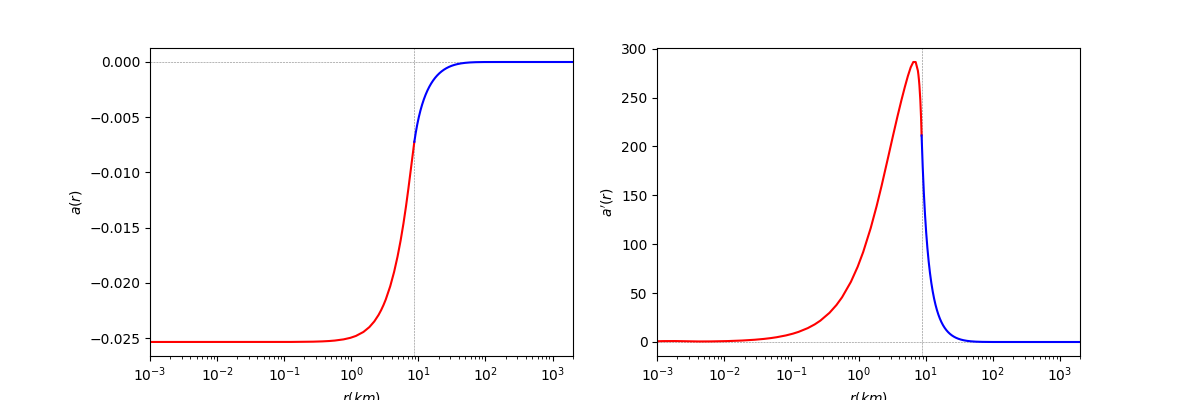

In [37]:
idx = 19
plt.close('all')
# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 4))  

plot_full_side_by_side(results[idx]["r_inside"], results[idx]["r_outside"], results[idx]["radius"], results[idx]["a_in"], results[idx]["a_out"], 'a(r)', subplot_index=1)
plot_full_side_by_side(results[idx]["r_inside"], results[idx]["r_outside"], results[idx]["radius"], results[idx]["a_prime_in"]*1e5, results[idx]["a_prime_out"]*1e5, 'a\'(r)', subplot_index=2)

plt.savefig("optimized_ac.pdf")
plt.show()

In [46]:
ax_mass = []
ax_radius = []
ax_rho_c = []
ax_a_c = []
for result in results:
    ax_mass.append(result["mass"])
    ax_radius.append(result["radius"]/1e5)
    ax_rho_c.append(result["rho"][0])
    ax_a_c.append(result["a_c"])

ax_mass = np.array(ax_mass)
ax_radius = np.array(ax_radius)

ax_MR_interp = interp1d(ax_radius, ax_mass, kind='quadratic')
radii = np.linspace(min(ax_radius), max(ax_radius), 10000)

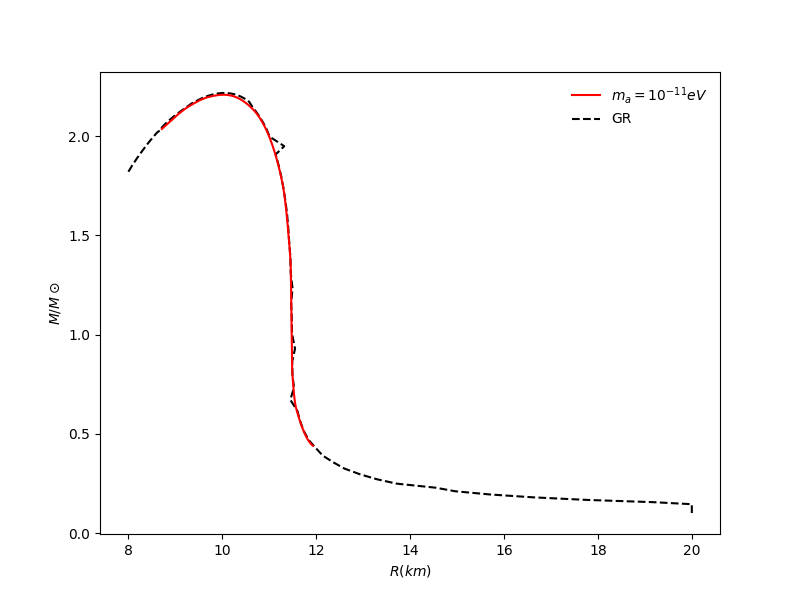

In [47]:
plt.close('all')
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(radii, ax_MR_interp(radii), 'r-', label=r"$m_a = 10^{-11} eV$")
ax.plot(GR_radius, GR_mass, 'k--',  label='GR', zorder=-1)
ax.set_xlabel(r"$R(km)$")
ax.set_ylabel(r"$M/M\odot$");
plt.legend(frameon=False)


In [8]:
a_minimized = []
for rho_c in ax_rho_c:
    with contextlib.redirect_stdout(io.StringIO()):
        a_min = axion_initial_guess(rho_c)
    a_minimized.append(a_min)

a_minimized = np.array(a_minimized)

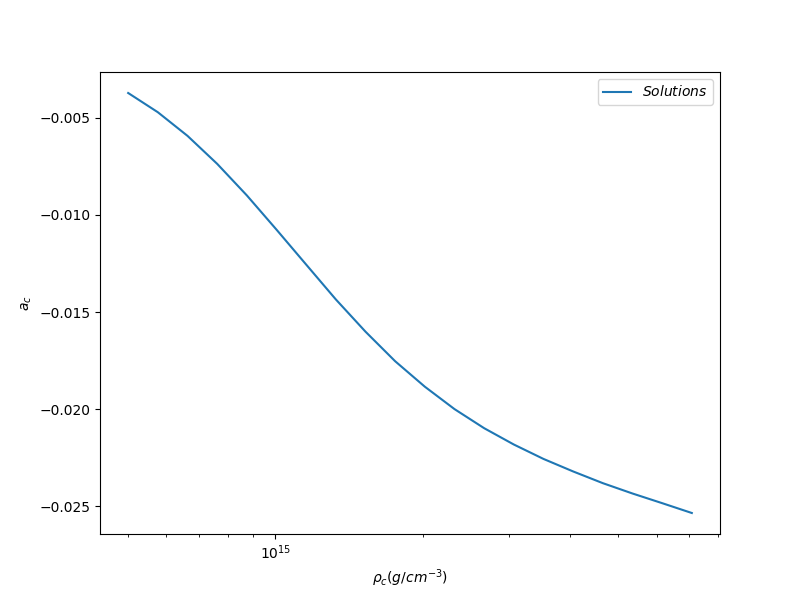

In [39]:
plt.close('all')
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(ax_rho_c, ax_a_c, label=r"$Solutions$")
#ax.plot(ax_rho_c, a_minimized, label=r"$Min(V_{eff})$")
ax.set_xlabel(r"$\rho_c (g/cm^{-3})$")
ax.set_ylabel(r"$a_c$");
ax.set_xscale("log")
plt.legend()